В этой тетрадке разберем основные техники работы в задачах, где один из классов занимает существенно меньшую долю выборки, чем остальные.

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
from sklearn.metrics import precision_recall_curve
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

 EDA

В качестве данных для нашей работы возьмем выложенный на kaggle датасет транзакций, в котором нужно выискивать мошеннические проводки: [клик](https://www.kaggle.com/mlg-ulb/creditcardfraud). Данная задача по определению подходит под несбалансированную, что можно сказать даже без наличия каких-либо данных (понятно, что среди всех транзакций клиентов очень малая часть будет мошеннической).

Загрузим данные, проведем некоторые классические манипуляции.

In [ ]:
"""%%bash
kaggle datasets download -d mlg-ulb/creditcardfraud
unzip creditcardfraud.zip""";

In [ ]:
!gdown --id "1RDNBmC-DO1LoAenN7IhlGJtv-lQK88n-" && unzip archive.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1RDNBmC-DO1LoAenN7IhlGJtv-lQK88n-
From (redirected): https://drive.google.com/uc?id=1RDNBmC-DO1LoAenN7IhlGJtv-lQK88n-&confirm=t&uuid=e5b6f3bb-91d5-4001-9629-55a18c303f28
To: /content/archive.zip
100% 69.2M/69.2M [00:01<00:00, 45.4MB/s]
Archive:  archive.zip
  inflating: creditcard.csv          


In [ ]:
df = pd.read_csv('creditcard.csv')

In [ ]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Наши данные были анонимизированы. Мы имеем 30 признаков, из которых 28 - это результаты PCA-преобразования на исходном датасете. Еще 2 признака представляют собой время в секундах, прошедшее с момента первой транзакции в датасете, и размер транзакции.

Найдем долю положительных объектов в выборке

In [ ]:
#your code here
df['Class'].mean()

0.001727485630620034

Начнем с обработки времени. Секунды сами по себе не несут большой информации о зависимостях в данных, попробуем по ним создать признаки "час" (от 0 до 23) и "день" (от 0 до ...)

In [ ]:
#your code here
df['Day'] = (df['Time'] // (60 * 60 * 24)).astype(int)
df['Hour'] = ((df['Time'] - df['Day']* 60 * 60 * 24) / 3600).astype(int)

In [ ]:
df["Day"].value_counts() # 2 дня(0 и 1)

Day
0    144786
1    140021
Name: count, dtype: int64

Построим следующие графики:

1. Распределение числа транзакций по каждому часу
2. Распределение доли мошеннических транзакций по каждому часу
3. То же самое для дней


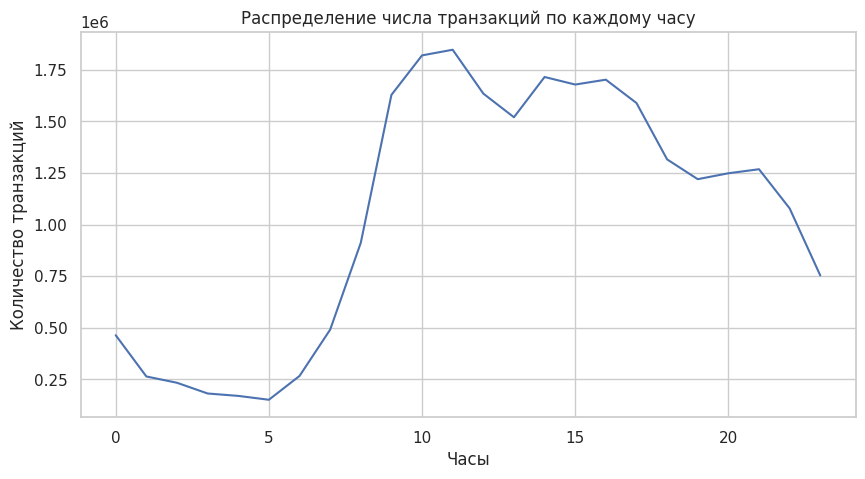

In [ ]:
#your code here
plt.figure(figsize=(10, 5))
plt.title('Распределение числа транзакций по каждому часу')
plt.xlabel('Часы')
plt.ylabel('Количество транзакций')
plt.plot(df.groupby(by='Hour')['Amount'].sum())
plt.show()

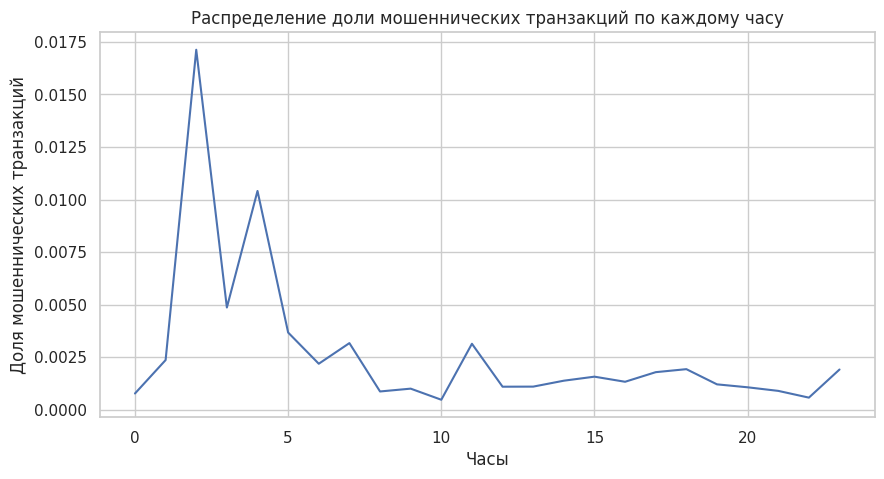

In [ ]:
#your code here
plt.figure(figsize=(10, 5))
plt.title('Распределение доли мошеннических транзакций по каждому часу')
plt.xlabel('Часы')
plt.ylabel('Доля мошеннических транзакций')
plt.plot(df.groupby(by='Hour')['Class'].mean())
plt.show()

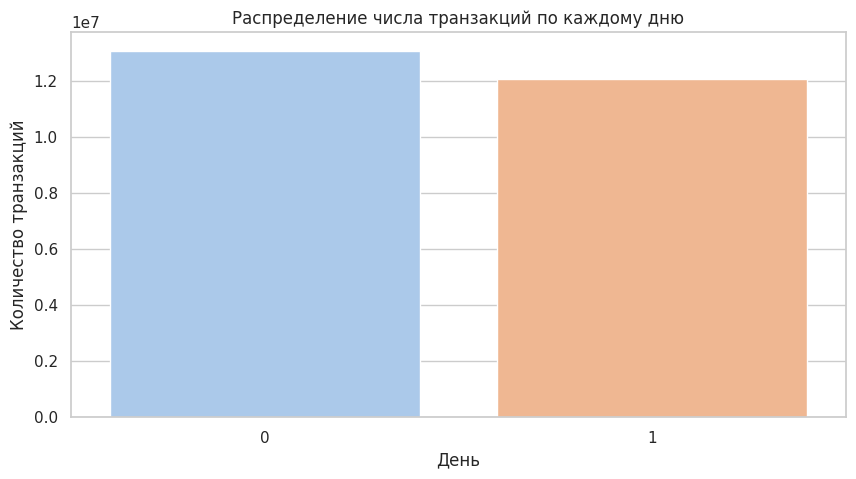

In [ ]:
#your code here
plt.figure(figsize=(10, 5))
plt.title('Распределение числа транзакций по каждому дню')
plt.xlabel('День')
plt.ylabel('Количество транзакций')
plot = sns.barplot(y=df.groupby(by='Day')['Amount'].sum(), x = [0, 1], palette="pastel")
plt.show()

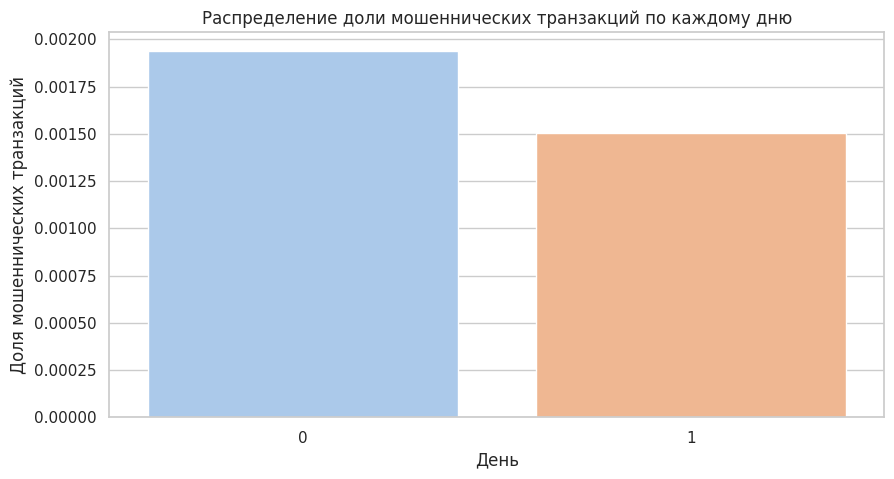

In [ ]:
#your code here
plt.figure(figsize=(10, 5))
plt.title('Распределение доли мошеннических транзакций по каждому дню')
plt.xlabel('День')
plt.ylabel('Доля мошеннических транзакций')
plot = sns.barplot(y=df.groupby(by='Day')['Class'].mean(), x = [0, 1], palette="pastel")
plt.show()

In [ ]:
df["Hour"].value_counts()

Hour
21    17703
18    17039
11    16856
20    16756
10    16598
14    16570
15    16461
16    16453
17    16166
9     15838
19    15649
22    15441
12    15420
13    15365
23    10938
8     10276
0      7695
7      7243
1      4220
6      4101
3      3492
2      3328
5      2990
4      2209
Name: count, dtype: int64

 большинство транзакций совершенно с 8 до 19 -  рабочий день. Мошеннические транзакции, наоборот, в основном ведутся в нерабочее время. Число мошеннических операций пропорционально числу операций всего.

С анонимизированными признаками вряд ли можно придумать что-то интересное. Попробуйте (например, с помощью корреляции?) выбрать несколько наиболее важных признаков и поглядеть на различия в их распределении для разных классов.

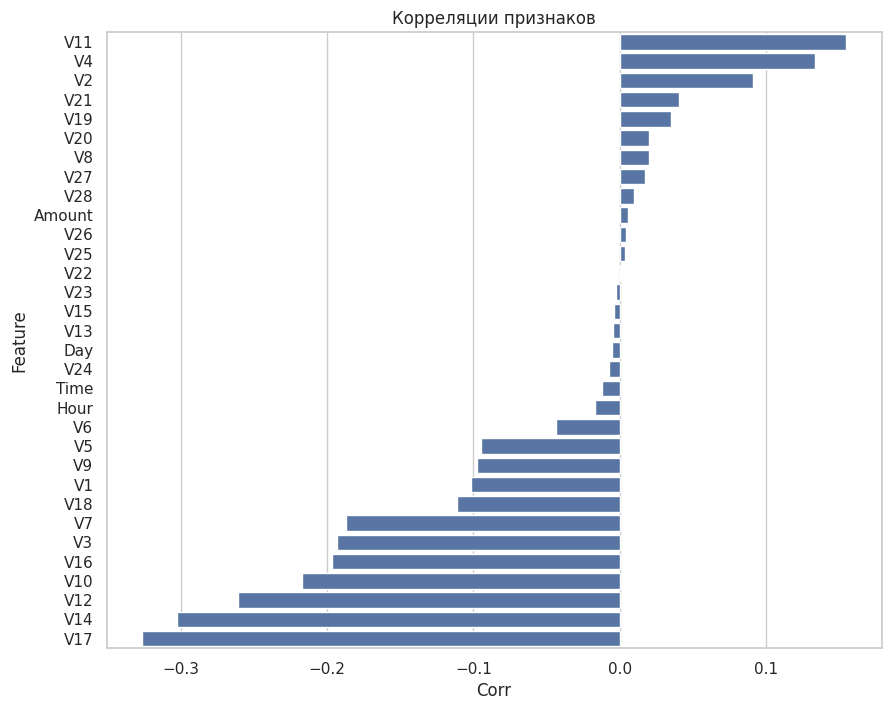

In [ ]:
#your code here
features = (list(df.columns))
features.remove('Class')
plt.figure(figsize=(10, 8))
plt.title('Корреляции признаков')
plt.xlabel('Corr')
plt.ylabel("Feature")
corrs = df[features].corrwith(df['Class']).sort_values(ascending=False)
plot = sns.barplot(y=corrs.index, x=corrs)

Видим, что наибольшую корреляцию с таргетом у нас имеют следующие переменные.

In [ ]:
features_corr = abs(corrs).sort_values(ascending=False)[:4]
features_corr.index.tolist()

['V17', 'V14', 'V12', 'V10']

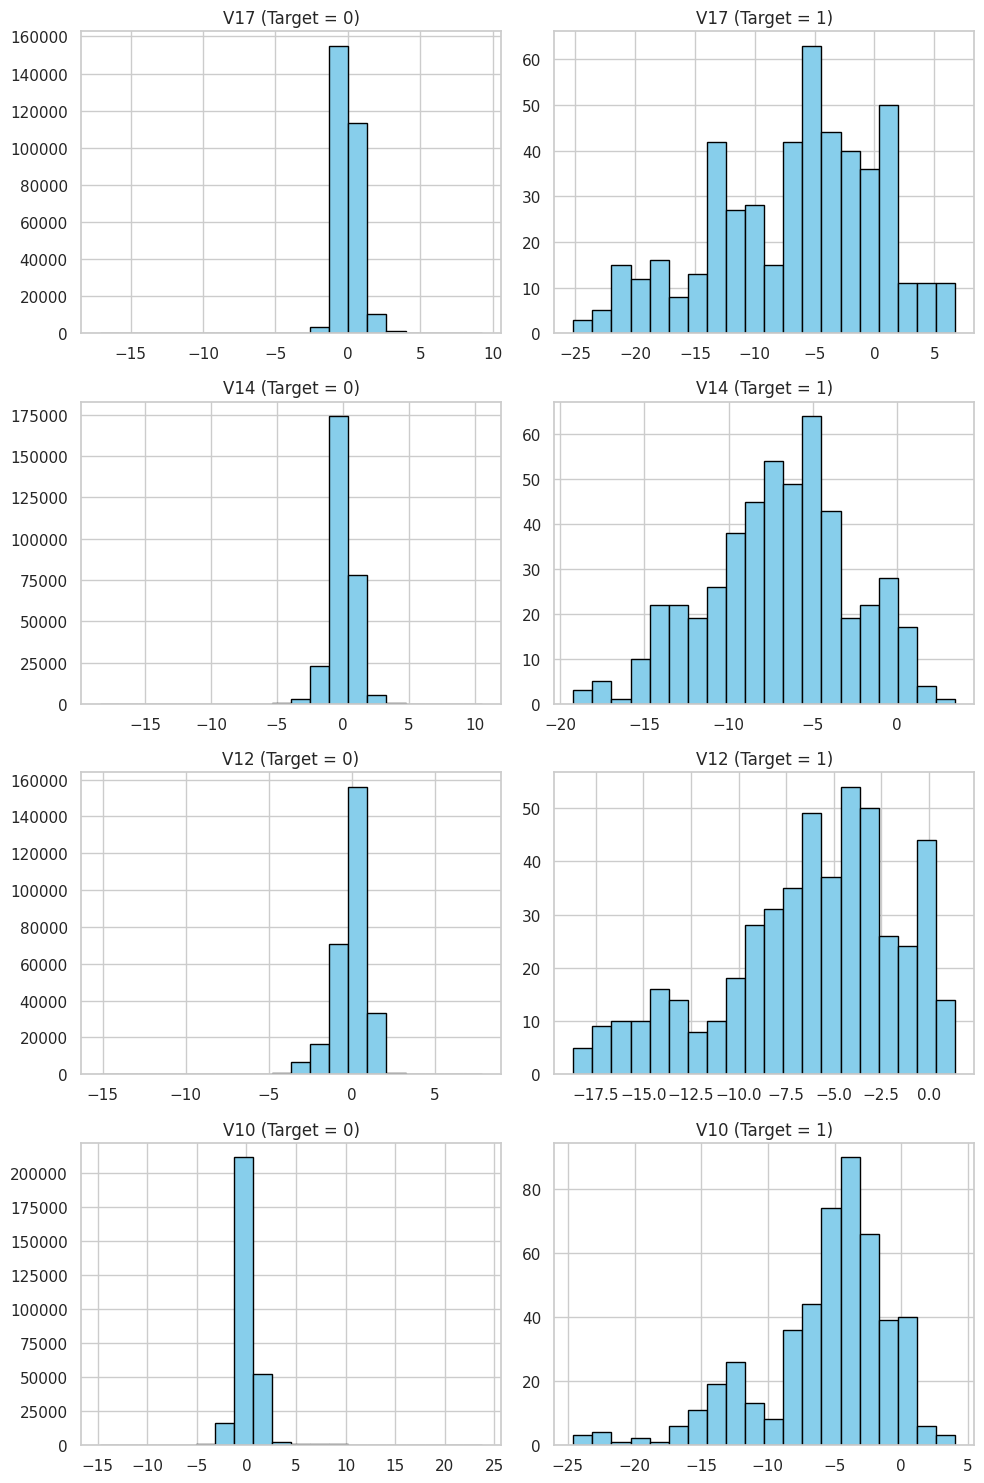

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(10, 15))
titles = features_corr.index.tolist()

for i in range(4):
    for j in range(2):
        data = df[df["Class"] == j][titles[i]]
        axs[i, j].hist(data, bins=20, color='skyblue', edgecolor='black')
        axs[i, j].set_title(f'{titles[i]} (Target = {j})')

plt.tight_layout()
plt.show()


Ну тут явно видим различие между значениями признаков для классов 0 и 1. Для мошеннических операций признаки принимают совершенно разные значения на большом промедутке значений, а для обычных - в основном около нуля и слабо расплывается по оси - короче дисперсия меньше

Теперь давайте разделим данные. Отделим хронологически последние 20% транзакций и поделите их пополам на валидационные и тестовые. Это разбиение не совсем корректно (как можно было заметить, мошеннические транзакции имеют разное распределение во времени - по-хорошему, нам стоило бы выделить целые сутки записей как под валидацию, так и под тест), тем не менее, обойдемся этим.

In [ ]:
from sklearn.model_selection import train_test_split
y = df["Class"]
X = df.drop(columns=["Class", "Time", "Day"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)

In [ ]:
X_train

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Hour
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227840,2.028950,-0.374089,-1.268051,0.349127,-0.057977,-0.515489,-0.087045,-0.146316,1.001341,0.007773,-1.307879,-0.003230,-0.684642,0.109699,-0.461828,-0.330118,-0.087021,-0.437197,0.222290,-0.194318,0.047287,0.323331,0.080683,0.727965,0.070118,0.723291,-0.083032,-0.061277,24.95,16
227841,0.306600,1.116021,-0.047348,3.593785,2.079047,5.748707,-2.059246,-1.352120,-1.849240,1.000154,-0.330464,-0.202383,-0.129313,0.713813,1.309414,0.399616,0.038217,-0.097967,0.632624,0.865457,-1.458527,-0.234478,0.258831,0.639005,-0.048250,0.144586,0.216385,0.304545,0.76,16
227842,-1.781954,2.062680,-3.758871,-1.801001,-0.084365,1.919610,-1.454364,-9.825473,-2.073119,-0.005816,-0.644403,0.982035,0.243801,1.541216,-1.949005,-1.278610,-0.179722,1.616439,-0.740407,-0.690810,1.234747,0.376804,-0.339706,-0.216688,-1.555393,0.655873,0.777662,0.272753,359.28,16
227843,-0.061507,1.024900,-0.170060,-0.263220,0.982164,-1.162749,1.468942,-0.648407,-0.157586,-0.764370,-0.442168,0.024224,0.865039,-1.203879,0.627917,-0.103494,0.238910,0.634188,-0.030689,0.035225,0.299618,1.177722,-0.296209,-0.140335,-0.465171,-0.197933,-0.048916,0.023871,39.40,16


# Несбалансированная классификация.

**Метрики качества для несбалансированной классификации**:
Классические метрики для качества классификации чаще всего "ломаются" на задачах с сильным перекосом.

мы можем использовать в таких задачах `AUC-PR` и получать адекватные показатели. Можно сказать, что `AUC-PR` представляет собой матожидание `precision` по распределению, заданному выигрышем в `recall` при смене порога.

In [ ]:
# from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc as gigaauc
def average_precision_score(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    return gigaauc(recall, precision)

Тем не менее, существуют и другие, не менее интересные метрики. Одной из таких метрик является коэффициент Каппа Коэна, представляющий собой нормализованную `accuracy`:


In [ ]:

from sklearn.metrics import cohen_kappa_score

In [ ]:

from sklearn.metrics import matthews_corrcoef

Обратите внимание, что эти метрики вычисляются на бинаризованных предсказаниях, поэтому может иметь смысл дополнительная настройка порога бинаризации.

In [ ]:

print(f'AUC-PR: {average_precision_score(y_test, [0]*y_test.shape[0])}')
print(f'kappa: {cohen_kappa_score(y_test, [0]*y_test.shape[0])}')
print(f'matthews: {matthews_corrcoef(y_test, [0]*y_test.shape[0])}')

AUC-PR: 0.5003862223938766
kappa: 0.0
matthews: 0.0


Давайте запустим бейзлайн-решение для нашей задачи - `catboost` на наших данных

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

In [ ]:

catboost = CatBoostClassifier(use_best_model=True, task_type = "GPU")
catboost.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)

In [ ]:
print(f'AUC-PR: {average_precision_score(y_test, catboost.predict_proba(X_test)[..., 1])}')
print(f'kappa: {cohen_kappa_score(y_test, catboost.predict(X_test))}')
print(f'matthews: {matthews_corrcoef(y_test, catboost.predict(X_test))}')

AUC-PR: 0.6775652960343049
kappa: 0.7498260790128315
matthews: 0.7536088618289372


**Добавим веса в катбуст**

In [ ]:
#your code here
_, counts = np.unique(y_train, return_counts=True)
catboost = CatBoostClassifier(use_best_model=True, scale_pos_weight=counts[0] / counts[1], task_type="GPU")
catboost.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)

In [ ]:
print(f'AUC-PR: {average_precision_score(y_test, catboost.predict_proba(X_test)[..., 1])}')
print(f'kappa: {cohen_kappa_score(y_test, catboost.predict(X_test))}')
print(f'matthews: {matthews_corrcoef(y_test, catboost.predict(X_test))}')

AUC-PR: 0.6886481592471054
kappa: 0.15569905875718437
matthews: 0.25153591404417874


Поскольку данный вес будет являться гиперпараметром метода, было бы опрометчиво остановиться на одном значении. Запустим перебор для этого гиперпараметра на валидационной выборке


In [ ]:
#your code here
best_scale, best_pr = 0, 0
for scale_pos in tqdm(np.linspace(0.5, 200, 20).astype(int)):
    catboost = CatBoostClassifier(scale_pos_weight=scale_pos, task_type="GPU")
    catboost.fit(X_train, y_train, verbose=False)

    pr_auc = average_precision_score(y_val, catboost.predict_proba(X_val)[..., 1])
    if pr_auc > best_pr:
        best_pr = pr_auc
        best_scale = scale_pos

100%|██████████| 20/20 [03:14<00:00,  9.74s/it]


In [ ]:
print(best_scale, best_pr)
catboost = CatBoostClassifier(scale_pos_weight=best_scale, task_type="GPU")
catboost.fit(X_train, y_train, verbose=False)

63 0.8708582138880535


Оптимальным получилось придавать гипервес минорному классу

In [ ]:
y_prob = catboost.predict_proba(X_val)[..., 1]
_, _, thresholds = precision_recall_curve(y_val, y_prob)
best_tresh, best_mcc = 0, 0
for tresh in thresholds:
    y_pred = y_prob > tresh
    mcc = matthews_corrcoef(y_val, y_pred)
    if mcc > best_mcc:
        best_mcc = mcc
        best_tresh = tresh

In [ ]:
print(best_tresh, best_mcc)
y_proba = catboost.predict_proba(X_test)[..., 1]
y_pred = y_proba > best_tresh
print(f'AUC-PR: {average_precision_score(y_test, y_proba)}')
print(f'kappa: {cohen_kappa_score(y_test, y_pred)}')
print(f'matthews: {matthews_corrcoef(y_test, y_pred)}')

0.7713366823353716 0.8793511804320202
AUC-PR: 0.7253940314311642
kappa: 0.7803305381421477
matthews: 0.7824309099074692


**SMOTE**.

Первый метод, которым мы воспользуемся, называется SMOTE. мы выбираем случайного кандидата среди $k$ ближайших соседей объекта минорного класса, затем берем точку на отрезке между двумя объектами и добавляем в выборку.

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
smote = SMOTE(random_state = 42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
catboost = CatBoostClassifier(use_best_model=True, task_type = "GPU")
catboost.fit(X_train_res, y_train_res, eval_set=(X_val, y_val), verbose=False)

In [ ]:
print(f'AUC-PR: {average_precision_score(y_test, catboost.predict_proba(X_test)[..., 1])}')
print(f'kappa: {cohen_kappa_score(y_test, catboost.predict(X_test))}')
print(f'matthews: {matthews_corrcoef(y_test, catboost.predict(X_test))}')

AUC-PR: 0.7361986169879998
kappa: 0.6663874946557107
matthews: 0.6687173797351023


In [ ]:
smote = SMOTE(random_state = 42, sampling_strategy = 0.1)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print(y_train_res.value_counts(), y_train.value_counts())
catboost = CatBoostClassifier(use_best_model=True, task_type = "GPU")
catboost.fit(X_train_res, y_train_res, eval_set=(X_val, y_val), verbose=False)

Class
0    227428
1     22742
Name: count, dtype: int64 Class
0    227428
1       417
Name: count, dtype: int64


In [ ]:
print(f'AUC-PR: {average_precision_score(y_test, catboost.predict_proba(X_test)[..., 1])}')
print(f'kappa: {cohen_kappa_score(y_test, catboost.predict(X_test))}')
print(f'matthews: {matthews_corrcoef(y_test, catboost.predict(X_test))}')

AUC-PR: 0.772423762827635
kappa: 0.7270618976581942
matthews: 0.7270618976581941


In [ ]:
smote = SMOTE(random_state = 42, sampling_strategy = 0.5)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print(y_train_res.value_counts(), y_train.value_counts())
catboost = CatBoostClassifier(use_best_model=True, task_type = "GPU")
catboost.fit(X_train_res, y_train_res, eval_set=(X_val, y_val), verbose=False)

Class
0    227428
1    113714
Name: count, dtype: int64 Class
0    227428
1       417
Name: count, dtype: int64


In [ ]:
print(f'AUC-PR: {average_precision_score(y_test, catboost.predict_proba(X_test)[..., 1])}')
print(f'kappa: {cohen_kappa_score(y_test, catboost.predict(X_test))}')
print(f'matthews: {matthews_corrcoef(y_test, catboost.predict(X_test))}')

AUC-PR: 0.7372557641054276
kappa: 0.6396882805812127
matthews: 0.6443525381406625


От стратегии сэмплирования метрики довольно сильно шатает. При 0.5 peak.

 Для vanilla SMOTE существуют некоторые модификации, часть из которых была реализована в библиотеке imblearn.


BorderlineSMOTE - в отличие от обычного SMOTE, которые сэмплит по всем миноритарным объектам, эта вариация делает следующее: 1) Определяет граничные точки - у которых есть минорные и мажорные соседи . 2) Определяет среди них шум - точки, у которых большее число соседей - мажорный класс. 3) По оставшимся граничным точкам сэмплит выборку как в Vanilla SMOTE. Таким образом, он сосредоточивается только на тех примерах, которые могут быть сложными для классификации из-за их близости к границе.

SVM-SMOTE - использует SVM для определения границы между классами и затем применяет vanilla SMOTE для генерации новых примеров вдоль этой границы. Основная идея состоит в том, чтобы использовать информацию о разделяющей границе, полученной из SVM, для более точного генерирования новых примеров, что может помочь улучшить качество классификации.

K-Means-SMOTE - объединяет в себе кластеризацию с помощью K-means и обычный SMOTE. Сначала входные данные разбивают на кластеры. Внутри полученных кластеров считается Imbalance Ratio(IR) = число минорных / число мажорных, и если оно больше 1(условно), то мы сэмплируем данные в этом кластере.

ADASYN - работает, генерируя синтетические образцы для классов меньшинств на основе пространства признаков исходного набора данных. Он вычисляет плотность распределения каждого образца класса меньшинств и генерирует синтетические образцы в соответствии с плотностью распределения. Такой адаптивный подход позволяет генерировать больше синтетических образцов для миноритарных классов, которые труднее поддаются обучению, что повышает эффективность классификации моделей машинного обучения.

Теперь попробуем сравнить качество всех методов на наших данных.

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE, KMeansSMOTE, SVMSMOTE, ADASYN

bord = BorderlineSMOTE(random_state = 42)
svm = SVMSMOTE(random_state = 42)
ada = ADASYN(random_state = 42)

X_train_res, y_train_res = bord.fit_resample(X_train, y_train)
print(y_train_res.value_counts(), y_train.value_counts())
catboost = CatBoostClassifier(use_best_model=True, task_type = "GPU")
catboost.fit(X_train_res, y_train_res, eval_set=(X_val, y_val), verbose=False)
print(f'AUC-PR: {average_precision_score(y_test, catboost.predict_proba(X_test)[..., 1])}')
print(f'kappa: {cohen_kappa_score(y_test, catboost.predict(X_test))}')
print(f'matthews: {matthews_corrcoef(y_test, catboost.predict(X_test))}')

Class
0    227428
1    227428
Name: count, dtype: int64 Class
0    227428
1       417
Name: count, dtype: int64
AUC-PR: 0.7271997729786344
kappa: 0.6805885875737472
matthews: 0.6819815751994611


In [ ]:
kms = KMeansSMOTE(random_state = 42, cluster_balance_threshold = 0)
X_train_res, y_train_res = kms.fit_resample(X_train, y_train)
catboost = CatBoostClassifier(use_best_model=True, task_type = "GPU")
catboost.fit(X_train_res, y_train_res, eval_set=(X_val, y_val), verbose=False)
print(f'AUC-PR: {average_precision_score(y_test, catboost.predict_proba(X_test)[..., 1])}')
print(f'kappa: {cohen_kappa_score(y_test, catboost.predict(X_test))}')
print(f'matthews: {matthews_corrcoef(y_test, catboost.predict(X_test))}')

AUC-PR: 0.7383428504895486
kappa: 0.6936167374627165
matthews: 0.6972625201268832


In [ ]:
X_train_res, y_train_res = svm.fit_resample(X_train, y_train)
catboost = CatBoostClassifier(use_best_model=True, task_type = "GPU")
catboost.fit(X_train_res, y_train_res, eval_set=(X_val, y_val), verbose=False)
print(f'AUC-PR: {average_precision_score(y_test, catboost.predict_proba(X_test)[..., 1])}')
print(f'kappa: {cohen_kappa_score(y_test, catboost.predict(X_test))}')
print(f'matthews: {matthews_corrcoef(y_test, catboost.predict(X_test))}')

AUC-PR: 0.7373617823176918
kappa: 0.6805885875737472
matthews: 0.6819815751994611


In [ ]:
X_train_res, y_train_res = ada.fit_resample(X_train, y_train)
catboost = CatBoostClassifier(use_best_model=True, task_type = "GPU")
catboost.fit(X_train_res, y_train_res, eval_set=(X_val, y_val), verbose=False)
print(f'AUC-PR: {average_precision_score(y_test, catboost.predict_proba(X_test)[..., 1])}')
print(f'kappa: {cohen_kappa_score(y_test, catboost.predict(X_test))}')
print(f'matthews: {matthews_corrcoef(y_test, catboost.predict(X_test))}')

AUC-PR: 0.7262586470433544
kappa: 0.5996536450902364
matthews: 0.6040259919536533


обычный SMOTE для нашей задачки в среднем по метрикам лучше справился, можно проверить для других соотношений, но мне лень 🤗

**Андерсэмплинг**.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

Class
0    227428
1       417
Name: count, dtype: int64
---------
Class
0    208500
1       417
Name: count, dtype: int64
---------
Class
0    4170
1     417
Name: count, dtype: int64
---------
Class
0    834
1    417
Name: count, dtype: int64
---------
Class
0    556
1    417
Name: count, dtype: int64
---------
Class
0    417
1    417
Name: count, dtype: int64
---------


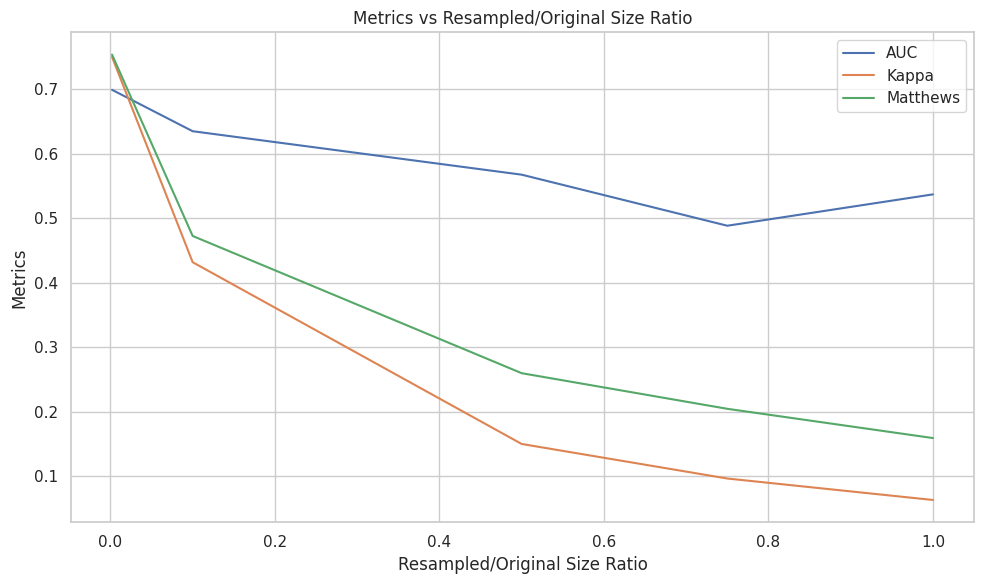

In [ ]:
catboost = CatBoostClassifier(use_best_model=True, task_type = "GPU")
balance_ratios = [0.002, 0.1, 0.5, 0.75, 1]
print(y_train.value_counts())
print("---------")
aucs = []
kappas = []
matthewss = []
resample_ratios = []

for balance_ratio in balance_ratios:
    under_sampler = RandomUnderSampler(sampling_strategy=balance_ratio, random_state=42)
    X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train, y_train)
    print(y_train_resampled.value_counts())
    print("---------")

    catboost.fit(X_train_resampled, y_train_resampled, eval_set=(X_val, y_val), verbose=False)

    aucc = average_precision_score(y_test, catboost.predict_proba(X_test)[..., 1])
    kappa = cohen_kappa_score(y_test, catboost.predict(X_test))
    matthews = matthews_corrcoef(y_test, catboost.predict(X_test))

    aucs.append(aucc)
    kappas.append(kappa)
    matthewss.append(matthews)
    resample_ratios.append(len(X_train_resampled) / len(X_train))


plt.figure(figsize=(10, 6))
plt.plot(balance_ratios, aucs, label='AUC')
plt.plot(balance_ratios, kappas, label='Kappa')
plt.plot(balance_ratios, matthewss, label='Matthews')
plt.xlabel('Resampled/Original Size Ratio')
plt.ylabel('Metrics')
plt.title('Metrics vs Resampled/Original Size Ratio')
plt.legend()

plt.tight_layout()
plt.show()

Очевидно, что если убирать большую часть выборки качество просядет.

Tomek Links -  это пары очень близких экземпляров, но относящихся к противоположным классам. Удаление экземпляров большинства классов в каждой паре увеличивает пространство между двумя классами, облегчая процесс классификации.


In [ ]:
from imblearn.under_sampling import TomekLinks

catboost = CatBoostClassifier(use_best_model=True, task_type="GPU")
tomek_links = TomekLinks()
X_train_resampled, y_train_resampled = tomek_links.fit_resample(X_train, y_train)

catboost.fit(X_train_resampled, y_train_resampled, eval_set=(X_val, y_val), verbose=False)

print(f'AUC-PR: {average_precision_score(y_test, catboost.predict_proba(X_test)[..., 1])}')
print(f'kappa: {cohen_kappa_score(y_test, catboost.predict(X_test))}')
print(f'matthews: {matthews_corrcoef(y_test, catboost.predict(X_test))}')


AUC-PR: 0.6732596346221652
kappa: 0.7498260790128315
matthews: 0.7536088618289372


Неплохо, но очень долго андерсэмплит + особо нет параметров которые можно подобрать

`пробуем 0.8`

In [ ]:
from imblearn.over_sampling import SMOTE
class BinaryClassificationModel(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassificationModel, self).__init__()
        self.layer_1 = nn.Linear(input_dim, 256)
        self.layer_2 = nn.Linear(256, 128)
        self.layer_3 = nn.Linear(128, 1)
        self.drop = nn.Dropout(p=0.2)
        # self.layer_4 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        # x = self.relu(self.layer_3(x))
        x = self.sigmoid(self.layer_3(x))
        return x

def mean_metrics(y_true, X, model, device):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        y_pred_proba = model(X_tensor).cpu().numpy().flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)

    kappa = cohen_kappa_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    auc_pr = average_precision_score(y_true, y_pred_proba)
    print(round(kappa, 4), round(mcc, 4), round(auc_pr, 4))
    return (kappa + mcc + auc_pr) / 3.0

def calculate_metrics(model, X, y):
    with torch.no_grad():
        y_score = model(X).cpu().numpy().flatten()
        y_pred = (y_score > 0.5).astype(int)

    kappa = cohen_kappa_score(y, y_pred)
    mcc = matthews_corrcoef(y, y_pred)
    auc_pr = average_precision_score(y, y_score)

    print("Cohen's Kappa:", kappa)
    print("Matthews Correlation Coefficient:", mcc)
    print("AUC-PR:", auc_pr)

smote_params = {
    'k_neighbors': [7],
    'sampling_strategy': np.linspace(0.002, 0.9, 5)
}

nearmiss_params = {
    'n_neighbors': [7],
    'sampling_strategy': [0.1, 0.3]
}

best_score = 0
best_params = None
best_estimator = None

input_dim = X_train.shape[1]
num_epochs = 30
batch_size = 2048
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32).to(device)

for smote_k in smote_params['k_neighbors']:
    for smote_strategy in smote_params['sampling_strategy']:
        # for nearmiss_k in nearmiss_params['n_neighbors']:
        #     for nearmiss_strategy in nearmiss_params['sampling_strategy']:
        #         print("Params ",smote_k, smote_strategy, nearmiss_k, nearmiss_strategy)
        #         nearmiss = NearMiss(n_neighbors=nearmiss_k, sampling_strategy=nearmiss_strategy)
        #         X_resampled, y_resampled = nearmiss.fit_resample(X_resampled, y_resampled)
                # smote = KMeansSMOTE(k_neighbors=smote_k, sampling_strategy=smote_strategy, cluster_balance_threshold = 0.0025, random_state=42)
                smote = SMOTE(k_neighbors=smote_k, random_state=42)
                X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
                # n_res, m_res = len(y_resampled[y_resampled == 0]), len(y_resampled[y_resampled == 1])
                # if n_res >= m_res / nearmiss_strategy:
                #     nearmiss = NearMiss(n_neighbors=nearmiss_k, sampling_strategy=nearmiss_strategy)
                #     X_resampled, y_resampled = nearmiss.fit_resample(X_resampled, y_resampled)

                X_resampled_array = X_resampled.to_numpy()
                y_resampled_array = y_resampled.to_numpy()

                train_dataset = TensorDataset(torch.tensor(X_resampled_array, dtype=torch.float32), torch.tensor(y_resampled_array, dtype=torch.float32))
                train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

                model = BinaryClassificationModel(input_dim).to(device)
                criterion = nn.BCELoss()
                optimizer = optim.Adam(model.parameters(), lr=learning_rate)
                scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)

                for epoch in tqdm(range(num_epochs), desc="epoch"):
                    model.train()
                    for X_batch, y_batch in train_loader:
                        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                        optimizer.zero_grad()
                        y_pred = model(X_batch).squeeze()
                        loss = criterion(y_pred, y_batch)
                        loss.backward()
                        optimizer.step()

                    scheduler.step(loss)

                    if (epoch + 1) % 5 == 0:
                        print(f'Epoch {epoch}')
                        calculate_metrics(model, X_test_tensor, y_test)

                score = mean_metrics(y_test, X_test_tensor, model, device)

                if score > best_score:
                    best_score = score
                    best_params = {
                        'smote__k_neighbors': smote_k,
                        'smote__sampling_strategy': smote_strategy
                        # 'nearmiss__n_neighbors': nearmiss_k,
                        # 'nearmiss__sampling_strategy': nearmiss_strategy
                    }
                    best_estimator = model

best_estimator.eval()
with torch.no_grad():
    y_score = best_estimator(X_test_tensor).cpu().numpy().flatten()
    y_pred = (y_score > 0.5).astype(int)


kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
auc_pr = average_precision_score(y_test, y_score)

print("Best Parameters:", best_params)
print("Cohen's Kappa:", kappa)
print("Matthews Correlation Coefficient:", mcc)
print("AUC-PR:", auc_pr)


epoch:  17%|█▋        | 5/30 [00:28<02:25,  5.83s/it]

Epoch 4
Cohen's Kappa: 0.2605894675126522
Matthews Correlation Coefficient: 0.34784201005619936
AUC-PR: 0.7202525347487736


epoch:  33%|███▎      | 10/30 [00:55<01:52,  5.65s/it]

Epoch 9
Cohen's Kappa: 0.30270578722827246
Matthews Correlation Coefficient: 0.38123410570874766
AUC-PR: 0.7485555006981521


epoch:  50%|█████     | 15/30 [01:23<01:23,  5.59s/it]

Epoch 14
Cohen's Kappa: 0.3000140930558567
Matthews Correlation Coefficient: 0.3791230054226517
AUC-PR: 0.738165938116323


epoch:  67%|██████▋   | 20/30 [01:50<00:55,  5.58s/it]

Epoch 19
Cohen's Kappa: 0.48516889791811235
Matthews Correlation Coefficient: 0.5226401816030567
AUC-PR: 0.7207872955901785


epoch:  83%|████████▎ | 25/30 [02:17<00:28,  5.60s/it]

Epoch 24
Cohen's Kappa: 0.4716553930030384
Matthews Correlation Coefficient: 0.5120520775041064
AUC-PR: 0.717541409662246


epoch: 100%|██████████| 30/30 [02:44<00:00,  5.50s/it]

Epoch 29
Cohen's Kappa: 0.4994769171606319
Matthews Correlation Coefficient: 0.5339108868073009
AUC-PR: 0.7215534384043067
0.4995 0.5339 0.7216



epoch:  17%|█▋        | 5/30 [00:27<02:20,  5.60s/it]

Epoch 4
Cohen's Kappa: 0.08958533549772374
Matthews Correlation Coefficient: 0.1913516443567737
AUC-PR: 0.6756895951032488


epoch:  33%|███▎      | 10/30 [00:54<01:51,  5.57s/it]

Epoch 9
Cohen's Kappa: 0.22119205511062123
Matthews Correlation Coefficient: 0.31562980883757474
AUC-PR: 0.7122366038042071


epoch:  50%|█████     | 15/30 [01:22<01:24,  5.63s/it]

Epoch 14
Cohen's Kappa: 0.31107711053437703
Matthews Correlation Coefficient: 0.3877839855233481
AUC-PR: 0.7130357645883745


epoch:  67%|██████▋   | 20/30 [01:49<00:56,  5.64s/it]

Epoch 19
Cohen's Kappa: 0.34973872536246675
Matthews Correlation Coefficient: 0.41779649109659944
AUC-PR: 0.7135793866859047


epoch:  83%|████████▎ | 25/30 [02:17<00:28,  5.63s/it]

Epoch 24
Cohen's Kappa: 0.3533966575366543
Matthews Correlation Coefficient: 0.42062174058490864
AUC-PR: 0.7131011939322154


epoch: 100%|██████████| 30/30 [02:44<00:00,  5.49s/it]

Epoch 29
Cohen's Kappa: 0.3533966575366543
Matthews Correlation Coefficient: 0.42062174058490864
AUC-PR: 0.7126373984366059
0.3534 0.4206 0.7126



epoch:  17%|█▋        | 5/30 [00:27<02:22,  5.70s/it]

Epoch 4
Cohen's Kappa: 0.3770506401989143
Matthews Correlation Coefficient: 0.4388600452532341
AUC-PR: 0.7129472543913659


epoch:  33%|███▎      | 10/30 [00:55<01:52,  5.63s/it]

Epoch 9
Cohen's Kappa: 0.21690954083035474
Matthews Correlation Coefficient: 0.3120503555794489
AUC-PR: 0.6921603917146809


epoch:  50%|█████     | 15/30 [01:23<01:24,  5.60s/it]

Epoch 14
Cohen's Kappa: 0.33920373133174053
Matthews Correlation Coefficient: 0.40964876149329543
AUC-PR: 0.7010773798226513


epoch:  67%|██████▋   | 20/30 [01:51<00:55,  5.57s/it]

Epoch 19
Cohen's Kappa: 0.40408239443338767
Matthews Correlation Coefficient: 0.4596820613881248
AUC-PR: 0.6932259785203796


epoch:  83%|████████▎ | 25/30 [02:18<00:27,  5.53s/it]

Epoch 24
Cohen's Kappa: 0.3946528785432547
Matthews Correlation Coefficient: 0.45241720891755566
AUC-PR: 0.691607528059616


epoch: 100%|██████████| 30/30 [02:46<00:00,  5.55s/it]

Epoch 29
Cohen's Kappa: 0.40408239443338767
Matthews Correlation Coefficient: 0.4596820613881248
AUC-PR: 0.6913052790957949
0.4041 0.4597 0.6913



epoch:  17%|█▋        | 5/30 [00:27<02:16,  5.45s/it]

Epoch 4
Cohen's Kappa: 0.21690954083035474
Matthews Correlation Coefficient: 0.3120503555794489
AUC-PR: 0.7389403107929674


epoch:  33%|███▎      | 10/30 [00:54<01:47,  5.37s/it]

Epoch 9
Cohen's Kappa: 0.21974601542463412
Matthews Correlation Coefficient: 0.31442314117138426
AUC-PR: 0.6862300613051919


epoch:  50%|█████     | 15/30 [01:22<01:22,  5.52s/it]

Epoch 14
Cohen's Kappa: 0.24719894622228245
Matthews Correlation Coefficient: 0.3370231487935079
AUC-PR: 0.7126885433996447


epoch:  67%|██████▋   | 20/30 [01:49<00:53,  5.40s/it]

Epoch 19
Cohen's Kappa: 0.3728917791894496
Matthews Correlation Coefficient: 0.43565610281431444
AUC-PR: 0.7169918945889432


epoch:  83%|████████▎ | 25/30 [02:16<00:27,  5.41s/it]

Epoch 24
Cohen's Kappa: 0.34973872536246675
Matthews Correlation Coefficient: 0.41779649109659944
AUC-PR: 0.7155919237027346


epoch: 100%|██████████| 30/30 [02:44<00:00,  5.48s/it]

Epoch 29
Cohen's Kappa: 0.34615541894415447
Matthews Correlation Coefficient: 0.41502711069377707
AUC-PR: 0.7112249577154907
0.3462 0.415 0.7112



epoch:  17%|█▋        | 5/30 [00:27<02:14,  5.38s/it]

Epoch 4
Cohen's Kappa: 0.09901755560922265
Matthews Correlation Coefficient: 0.19620149351865795
AUC-PR: 0.6067823522494201


epoch:  33%|███▎      | 10/30 [01:04<02:27,  7.37s/it]

Epoch 9
Cohen's Kappa: 0.28740560099446555
Matthews Correlation Coefficient: 0.36073725620978075
AUC-PR: 0.6799375709357499


epoch:  50%|█████     | 15/30 [01:44<01:59,  7.95s/it]

Epoch 14
Cohen's Kappa: 0.3360539178229798
Matthews Correlation Coefficient: 0.3985098129655076
AUC-PR: 0.6464766695612919


epoch:  67%|██████▋   | 20/30 [02:11<01:00,  6.00s/it]

Epoch 19
Cohen's Kappa: 0.3068479889238024
Matthews Correlation Coefficient: 0.3759005143200728
AUC-PR: 0.6454245117792797


epoch:  83%|████████▎ | 25/30 [02:38<00:28,  5.60s/it]

Epoch 24
Cohen's Kappa: 0.32572277578615927
Matthews Correlation Coefficient: 0.39052915287019085
AUC-PR: 0.6434558032363507


epoch: 100%|██████████| 30/30 [03:06<00:00,  6.21s/it]

Epoch 29
Cohen's Kappa: 0.32572277578615927
Matthews Correlation Coefficient: 0.39052915287019085
AUC-PR: 0.6423195775741586
0.3257 0.3905 0.6423
Best Parameters: {'smote__k_neighbors': 7, 'smote__sampling_strategy': 0.002}
Cohen's Kappa: 0.4994769171606319
Matthews Correlation Coefficient: 0.5339108868073009
AUC-PR: 0.7215534384043067


In [ ]:
def mean_metrics(y_true, X, classifier):
    kappa = cohen_kappa_score(y_true, classifier.predict(X))
    mcc = matthews_corrcoef(y_true, classifier.predict(X))
    auc_pr = average_precision_score(y_true, classifier.predict_proba(X)[:, 1])
    print(round(kappa,4), round(mcc,4), round(auc_pr, 4))
    return (kappa + mcc + auc_pr) / 3.0

smote_params = {
    'k_neighbors': [3, 9],
    'sampling_strategy': [0.1, 0.35, 0.5, 1.0]
}

nearmiss_params = {
    'n_neighbors': [3, 9],
    'sampling_strategy': [0.1, 0.35, 0.5, 1.0]
}

best_score = 0
best_params = None
best_estimator = None
n = len(y_train[y_train == 0])
m = len(y_train[y_train == 1])

for smote_k in tqdm(smote_params['k_neighbors'], desc="SMOTE k_neighbors"):
    for smote_strategy in tqdm(smote_params['sampling_strategy'], leave=False, desc="SMOTE sampling_strategy"):
        for nearmiss_k in tqdm(nearmiss_params['n_neighbors'], leave=False, desc="NearMiss n_neighbors"):
            for nearmiss_strategy in tqdm(nearmiss_params['sampling_strategy'], leave=False, desc="NearMiss sampling_strategy"):

                smote = BorderlineSMOTE(k_neighbors=smote_k, sampling_strategy=smote_strategy)
                X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

                n_res, m_res = len(y_resampled[y_resampled == 0]), len(y_resampled[y_resampled == 1])
                if n_res >= m_res / nearmiss_strategy:
                    nearmiss = NearMiss(n_neighbors=nearmiss_k, sampling_strategy=nearmiss_strategy)
                    X_resampled, y_resampled = nearmiss.fit_resample(X_resampled, y_resampled)

                classifier = CatBoostClassifier(silent=True, random_state=42, use_best_model = True)
                classifier.fit(X_resampled, y_resampled, eval_set = (X_val, y_val))

                score = mean_metrics(y_test, X_test, classifier)

                if score > best_score:
                    best_score = score
                    best_params = {
                        'smote__k_neighbors': smote_k,
                        'smote__sampling_strategy': smote_strategy,
                        'nearmiss__n_neighbors': nearmiss_k,
                        'nearmiss__sampling_strategy': nearmiss_strategy
                    }
                    best_estimator = classifier



y_score = best_estimator.predict_proba(X_test)[:, 1]
y_pred = best_estimator.predict(X_test)

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
auc_pr = average_precision_score(y_test, y_score)

print("Best Parameters:", best_params)
print("Cohen's Kappa:", kappa)
print("Matthews Correlation Coefficient:", mcc)
print("AUC-PR:", auc_pr)


SMOTE sampling_strategy:   0%|          | 0/4 [00:00<?, ?it/s]

NearMiss n_neighbors:   0%|          | 0/2 [00:00<?, ?it/s]


NearMiss sampling_strategy:   0%|          | 0/4 [00:00<?, ?it/s]


NearMiss sampling_strategy:  25%|██▌       | 1/4 [01:41<05:04, 101.50s/it]

0.6806 0.682 0.69





NearMiss sampling_strategy:  50%|█████     | 2/4 [02:43<02:36, 78.41s/it] 

0.2798 0.3548 0.6424





NearMiss sampling_strategy:  75%|███████▌  | 3/4 [03:41<01:08, 68.83s/it]

0.1596 0.2551 0.7024





NearMiss sampling_strategy: 100%|██████████| 4/4 [04:34<00:00, 62.71s/it]


                                                                         

NearMiss n_neighbors:  50%|█████     | 1/2 [04:34<04:34, 274.53s/it]

0.0793 0.1742 0.6865





NearMiss sampling_strategy:   0%|          | 0/4 [00:00<?, ?it/s]


NearMiss sampling_strategy:  25%|██▌       | 1/4 [01:42<05:07, 102.55s/it]

0.6954 0.6961 0.7234





NearMiss sampling_strategy:  50%|█████     | 2/4 [02:42<02:35, 77.77s/it] 

0.2571 0.3368 0.6642





NearMiss sampling_strategy:  75%|███████▌  | 3/4 [03:41<01:09, 69.16s/it]

0.1747 0.2685 0.6523





NearMiss sampling_strategy: 100%|██████████| 4/4 [04:33<00:00, 62.19s/it]


                                                                         

NearMiss n_neighbors: 100%|██████████| 2/2 [09:07<00:00, 273.87s/it]

                                                                    
SMOTE sampling_strategy:  25%|██▌       | 1/4 [09:07<27:23, 547.96s/it]

0.1057 0.2033 0.7051




NearMiss n_neighbors:   0%|          | 0/2 [00:00<?, ?it/s]


NearMiss sampling_strategy:   0%|          | 0/4 [00:00<?, ?it/s]


NearMiss sampling_strategy:  25%|██▌       | 1/4 [01:24<04:13, 84.50s/it]

0.615 0.6225 0.7244





NearMiss sampling_strategy:  50%|█████     | 2/4 [04:32<04:51, 145.51s/it]

0.6806 0.682 0.7044





NearMiss sampling_strategy:  75%|███████▌  | 3/4 [07:39<02:44, 164.16s/it]

0.4995 0.5259 0.661





NearMiss sampling_strategy: 100%|██████████| 4/4 [10:54<00:00, 176.48s/it]


                                                                          

NearMiss n_neighbors:  50%|█████     | 1/2 [10:54<10:54, 654.45s/it]

0.2922 0.373 0.6825





NearMiss sampling_strategy:   0%|          | 0/4 [00:00<?, ?it/s]


NearMiss sampling_strategy:  25%|██▌       | 1/4 [01:29<04:27, 89.21s/it]

0.6664 0.6687 0.6919





NearMiss sampling_strategy:  50%|█████     | 2/4 [05:42<06:11, 185.83s/it]

0.6664 0.6687 0.7228





NearMiss sampling_strategy:  75%|███████▌  | 3/4 [08:35<03:00, 180.04s/it]

0.4096 0.4552 0.6591





NearMiss sampling_strategy: 100%|██████████| 4/4 [11:08<00:00, 169.04s/it]


                                                                          

NearMiss n_neighbors: 100%|██████████| 2/2 [22:02<00:00, 662.43s/it]

                                                                    
SMOTE sampling_strategy:  50%|█████     | 2/4 [31:10<33:27, 1003.56s/it]

0.3054 0.3834 0.6847




NearMiss n_neighbors:   0%|          | 0/2 [00:00<?, ?it/s]


NearMiss sampling_strategy:   0%|          | 0/4 [00:00<?, ?it/s]


NearMiss sampling_strategy:  25%|██▌       | 1/4 [01:23<04:11, 83.77s/it]

0.5922 0.6027 0.7166





NearMiss sampling_strategy:  50%|█████     | 2/4 [02:48<02:48, 84.20s/it]

0.5814 0.5934 0.7132





NearMiss sampling_strategy:  75%|███████▌  | 3/4 [06:48<02:35, 155.55s/it]

0.615 0.6225 0.7423


In [ ]:
class BinaryClassificationModel(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassificationModel, self).__init__()
        self.layer_1 = nn.Linear(input_dim, 256)
        self.layer_2 = nn.Linear(256, 128)
        self.layer_3 = nn.Linear(128, 1)
        # self.drop = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer_1(x))
        # x = self.drop(x)
        x = self.relu(self.layer_2(x))
        # x = self.drop(x)
        x = self.sigmoid(self.layer_3(x))
        return x

input_dim = X_train.shape[1]
num_epochs = 25
batch_size = 1024
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32).to(device)

smote = KMeansSMOTE(k_neighbors=7, sampling_strategy=0.8, cluster_balance_threshold=0.0025, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

X_resampled_array = X_resampled.to_numpy()
y_resampled_array = y_resampled.to_numpy()

train_dataset = TensorDataset(torch.tensor(X_resampled_array, dtype=torch.float32), torch.tensor(y_resampled_array, dtype=torch.float32))
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

model = BinaryClassificationModel(input_dim).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)

for epoch in tqdm(range(num_epochs), desc="epoch"):
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    scheduler.step(epoch_loss)

model.eval()
with torch.no_grad():
    y_score = model(X_test_tensor).cpu().numpy().flatten()
    y_pred = (y_score > 0.5).astype(int)

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
auc_pr = average_precision_score(y_test, y_score)

print("Cohen's Kappa:", kappa)
print("Matthews Correlation Coefficient:", mcc)
print("AUC-PR:", auc_pr)


epoch: 100%|██████████| 25/25 [01:55<00:00,  4.64s/it]

Cohen's Kappa: 0.6396882805812127
Matthews Correlation Coefficient: 0.6443525381406625
AUC-PR: 0.663006508406583


по моему получилось что оверсэмплеры не улучшают ничего
я попробовал и катбуст и сетки, AUC-PR не вышло выше 0.76(но не на показательном трае) поднять, но остальные метрики выше 0.8

Я без понятия почему сейчас такие слабые метрики, random_state вроде зафиксирован, все то же самое, но метрики вообще другие. Как обычно за час перед дедлайном такое случается...






# Поиск аномалий.

Как часто бывает в задачах, связанных с балансировкой выборок, стандартные методы могут не всегда давать наилучшие результаты. Это связано с тем, что такие методы могут искажать информацию о реальном распределении данных. В реальных условиях требуется тщательный подбор подходящих методов и их точная настройка.

Теперь давайте сменим акцент и перейдем к задаче “одноклассовой” классификации, которая часто используется для обнаружения аномалий в данных. Это хорошо согласуется с нашей областью работы, так как мошеннические транзакции можно рассматривать как аномалии, что подтверждается как интуитивно, так и на основе наблюдаемой дисбалансировки данных.

Методы обнаружения аномалий обычно относятся к классу методов обучения без учителя, что имеет свои преимущества — не всегда нужно тратить время на разметку данных. Однако для контроля качества все же стоит разметить часть данных. Хотя такие методы часто уступают в производительности методам обучения с учителем, они остаются полезными, когда разметка данных затруднена.

В рамках нашей работы мы будем использовать подход, аналогичный Random Forest, для детекции аномалий без разметки данных — это алгоритм Isolation Forest. В процессе обучения создается ансамбль решающих деревьев, в котором признаки и пороги для каждой вершины выбираются случайно. Оценка аномальности объекта определяется через длину пути до листа в каждом дереве.

Задача заключается в реализации модифицированной версии этого алгоритма, известной как Extended Isolation Forest. В этом варианте на каждом шаге мы будем определять не просто порог для признака, а полноценную случайную гиперплоскость, которая разделяет выборку на две части.

Примечания:

	•	В нашей задаче предполагается, что в датасете нет категориальных признаков, поэтому их обработку можно пропустить.
	•	Численные признаки рекомендуется предварительно обработать надлежащим образом.
	•	Важно тщательно следить за корректностью знаков в расчетах.
	•	Хотя методы обучения без учителя часто уступают supervised-решениям по качеству, это не повод сомневаться в правильности подхода, если вы уверены в своих действиях.

Для дальнейшего развития можно рассмотреть возможность параллелизации алгоритма с использованием multiprocessing или joblib, а также добавить функциональность отката к базовому варианту Isolation Forest. Важно обдумать, как эта возможность может быть реализована в рамках модели Extended Isolation Forest.

In [ ]:
from joblib import Parallel, delayed
def c_factor(n):
    """
    Computes average path length for an unsuccessful search in a binary search tree.
    Params:
        n: int - number of data points for BST
    """
    if n <= 1:
        return 0
    return 2 * (np.log(n - 1) + np.euler_gamma) - (2 * (n - 1) / n)


def calc_height(X, depth, node):
    """
    Calculates anomaly scores for sample in a recursive manner.
    Params:
        X: np.array - current sample, available to node

        depth: int - path length up to current node

        node: Node - current tree node

    Returns:
        scores: int, float or np.array - anomaly scores for sample
    """
    if node.kind == "external":
        return depth + c_factor(node.size)

    side = np.dot(X, node.w) + node.b <= 0
    left_indices = side
    right_indices = ~side

    scores = np.zeros(X.shape[0])
    if node.left:
        scores[left_indices] = calc_height(X[left_indices], depth + 1, node.left)
    if node.right:
        scores[right_indices] = calc_height(X[right_indices], depth + 1, node.right)

    return scores


class Node(object):
    """
    A single node object for each tree. Contains information on height, current data,
    splitting hyperplane and children nodes.

    Attributes:
        X: np.array - data available to current node
        size: int - length of available data

        depth: int - depth of node

        left: Node - left child
        right: Node - right child

        kind: str - either "internal" or "external", indicates the type of current node

        w: np.array - normal vector for the splitting hyperplane
        b: float - intercept term for the splitting hyperplane
    """
    def __init__(self, X, depth, left=None, right=None, kind="external", w=None, b=None):
        """
        Node(h, left, right, kind, w, b)
        Represents the node object.

        Params:
            X: np.array - data available to current node
            depth: int - depth of node

            left: Node - left child
            right: Node - right child

            kind: str - either "internal" or "external", indicates the type of current node

            w: np.array - normal vector for the splitting hyperplane
            b: float - intercept term for the splitting hyperplane

        """
        self.size = len(X)
        self.depth = depth
        self.left = left
        self.right = right
        self.kind = kind
        self.w = w
        self.b = b

    def __repr__(self):
        """
        For convenience only.
        """
        return f"Node(size={self.size}, depth={self.depth}, kind={self.kind})"


class RandomizedTree(object):
    """
    Single randomized tree object. Stores root and its depth (tree is built recursively).
    Attributes:
        depth: int - current tree depth

        max_depth: int - maximum tree depth

        root: Node - root node

        internal_count: int - number of internal nodes

        external_count: int - number of external nodes

    """
    def __init__(self, X, max_depth):
        """
        Single randomized tree object. Stores root and its depth (tree is built recursively).
        Params:
            X: np.array - train sample
            max_depth: int - maximum tree depth

        """
        self.depth = 0
        self.max_depth = max_depth
        self.internal_count = 0
        self.external_count = 0
        self.root = self.grow(X, 0)

    def __repr__(self):
        """
        For convenience only.
        """
        return f"RandomizedTree(depth={self.depth}, max_depth={self.max_depth}, n_internal={self.internal_count}, n_external={self.external_count})"

    def grow(self, X, depth):
        """
        Grow tree in a recursive manner.
        Params:
            X: np.array - available train sample

            depth: int - current tree depth

        Returns:
            node: Node - a trained node with separating hyperplane data.
                         Node provides access to children if necessary (these are built recursively)
        """
        if depth >= self.max_depth or len(X) <= 1:
            self.external_count += 1
            return Node(X, depth, kind="external")

        self.internal_count += 1

        dim = X.shape[1]
        w = np.random.normal(size=dim)
        w /= np.linalg.norm(w)
        b = np.random.uniform(np.min(np.dot(X, w)), np.max(np.dot(X, w)))

        left_indices = np.dot(X, w) + b <= 0
        right_indices = ~left_indices

        left_child = self.grow(X[left_indices], depth + 1)
        right_child = self.grow(X[right_indices], depth + 1)

        return Node(X, depth, left_child, right_child, kind="internal", w=w, b=b)

    def score_samples(self, X):
        """
        Calculate anomaly scores for given data. You may utilize outer function `calc_height`.
        Params:
            X: np.array - data to be evaluated

        Returns:
            scores: np.array - estimated anomaly scores
        """
        return calc_height(X, 0, self.root)


class ExtendedIsolationForest(object):
    """
    Extended Isolation Forest object. Stores training data and trained randomized trees.
    Attributes:
        n_trees: int - number of Randomized Trees

        max_depth: int - maximum depth of each tree

        subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree

        trees: list - container for trained trees

        contamination: float - estimated fraction of anomaly samples in data. Used for thresholding

    """

    def __init__(self, n_trees, subsample_rate, max_depth=None, contamination=0.01, use_sklearn_if = False, n_jobs = 1):
        """
        Extended Isolation Forest object. Stores training data and trained randomized trees.
        Params:
            n_trees: int - number of Randomized Trees

            subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree

            max_depth: int or None - maximum depth of each tree. Defaults to ceil(log_2(subsample_size)) if not provided

            contamination: float - estimated fraction of anomaly samples in data. Used for thresholding

        """
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.subsample_rate = subsample_rate
        self.trees = []
        self.contamination = contamination
        self.use_sklearn_if = use_sklearn_if
        self.is_fit = False
        self.n_jobs = n_jobs

        if self.use_sklearn_if:
            self.model = IsolationForest(n_estimators=n_trees, max_samples=subsample_rate, contamination=contamination, n_jobs=n_jobs)


    def __repr__(self):
        """For convenience only."""
        return f"ExtendedIsolationForest(n_trees={self.n_trees}, max_depth={self.max_depth}, subsample_rate={self.subsample_rate}, contamination={self.contamination}, is_fit={self.is_fit})"

    def fit(self, X):
        """
        Fit EIF to new data.
        Params:
            X: np.array - 2d array of samples
        """
        if self.use_sklearn_if:
            self.model.fit(X)
            self.is_fit = True
            return self

        n_samples = X.shape[0]
        subsample_size = int(self.subsample_rate * n_samples)
        self.max_depth = self.max_depth or int(np.ceil(np.log2(subsample_size)))

        def build_tree(X_sub):
            return RandomizedTree(X_sub, self.max_depth)

        self.trees = Parallel(n_jobs=self.n_jobs)(delayed(build_tree)(X[np.random.choice(n_samples, subsample_size, replace=False)]) for _ in range(self.n_trees))

        self.is_fit = True
        return self

    def score_samples(self, X):
        """
        Estimate (normalized) anomaly score for each given sample
        Params:
            X: np.array - new samples

        Returns:
            scores: np.array - anomaly scores (larger value means higher probability of a sample being an outlier)
        """
        if self.use_sklearn_if:
            return -self.model.decision_function(X)

        if not self.is_fit:
            raise Exception("Model is not fit yet.")

        scores = np.zeros(X.shape[0])
        for tree in self.trees:
            scores += tree.score_samples(X)

        scores /= len(self.trees)
        return np.power(2, -scores / c_factor(X.shape[0]))

    def predict(self, X):
        """
        Predict if given samples are outliers.
        Params:
            X: np.array - new samples

        Returns:
            labels: np.array - anomaly labels (1 for outliers, 0 for inliers)
        """
        scores = self.score_samples(X)
        threshold = np.percentile(scores, 100 * (1 - self.contamination))
        return (scores >= threshold).astype(int)

**Протестируем и подберем гиперпараметры**

In [ ]:
y_train.value_counts()[1] / y_train.value_counts()[0]

0.0018335473204706544

In [ ]:
import itertools
X_train_np = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
# X_test_np = X_test.values if isinstance(X_test, pd.DataFrame) else X_test
# X_val_np = X_val.values if isinstance(X_val, pd.DataFrame) else X_val

param_grid = {
    'n_trees': [100],
    'max_depth': [15, 25],
    'subsample_rate': [0.075, 0.15],
    'contamination': [0.01, 0.05]
}

best_auc_pr = float('-inf')
best_params = None
n = len(list(itertools.product(*param_grid.values())))
i = 0

for n_trees in param_grid['n_trees']:
    for max_depth in param_grid['max_depth']:
        for subsample_rate in param_grid['subsample_rate']:
            for contamination in param_grid['contamination']:
                eiforest = ExtendedIsolationForest(n_trees=n_trees, max_depth=max_depth, subsample_rate=subsample_rate, contamination=contamination)
                eiforest.fit(X_train_np)

                y_pred= eiforest.predict(X_train_np)
                auc_pr = average_precision_score(y_train, y_pred)

                if auc_pr > best_auc_pr:
                    best_auc_pr = auc_pr
                    best_params = {'n_trees': n_trees, 'max_depth': max_depth, 'subsample_rate': subsample_rate, 'contamination': contamination}
                i += 1
                print(f"{i} / {n}")

print("Best AUC-PR:", best_auc_pr)
print("Best params:", best_params)


1 / 8
2 / 8
3 / 8
4 / 8
5 / 8
6 / 8
7 / 8
8 / 8
Best AUC-PR: 0.0019493324686029288
Best params: {'n_trees': 50, 'max_depth': 15, 'subsample_rate': 0.075, 'contamination': 0.01}


In [ ]:
#your code here
from sklearn.ensemble import IsolationForest
X_train_np = X_train.values if isinstance(X_train, pd.DataFrame) else X_train

iforest_sklearn = IsolationForest(n_estimators=100, contamination=0.15, max_samples=0.3, random_state=42)
iforest_sklearn.fit(X_train)
y_pred_sklearn = -iforest_sklearn.predict(X_train_np)
y_predp_sklearn = iforest_sklearn.score_samples(X_train_np)


eiforest = ExtendedIsolationForest(n_trees=100, subsample_rate=0.3, contamination=0.15, max_depth=15)
eiforest.fit(X_train_np)

y_pred_eiforest = eiforest.predict(X_train_np)
y_predp_eiforest = eiforest.score_samples(X_train_np)

auc_pr_sklearn = aps(y_train, y_predp_sklearn)
auc_pr_eiforest = aps(y_train, y_predp_eiforest)
kappa_sklearn = cohen_kappa_score(y_train, y_pred_sklearn)
kappa_eiforest = cohen_kappa_score(y_train, y_pred_eiforest)
matthews_sklearn =  matthews_corrcoef(y_train, y_pred_sklearn)
matthews_eiforest =  matthews_corrcoef(y_train, y_pred_eiforest)

print("AUC-PR for IsolationForest (scikit-learn):", auc_pr_sklearn)
print("AUC-PR for ExtendedIsolationForest:", auc_pr_eiforest)
print("kappa for IsolationForest (scikit-learn):", kappa_sklearn)
print("kappa for ExtendedIsolationForest:", kappa_eiforest)
print("matthews for IsolationForest (scikit-learn):", matthews_sklearn)
print("matthews for ExtendedIsolationForest:", matthews_eiforest)

AUC-PR for IsolationForest (scikit-learn): 0.000926118912501819
AUC-PR for ExtendedIsolationForest: 0.12545174085722227
kappa for IsolationForest (scikit-learn): 0.001398042487872897
kappa for ExtendedIsolationForest: 0.017259010316484247
matthews for IsolationForest (scikit-learn): 0.04578932479355712
matthews for ExtendedIsolationForest: 0.08553954013661585


EIF круче получился но не очень все равно
